In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['Device:', 'rrqm/s', 'wrqm/s', 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'avgrq-sz', 'avgqu-sz',
                  'await', 'r_await', 'w_await', 'svctm', '%util']
TEST_CONFIG = 'max-rate-submit'
DISK_CONFIG = 'ssd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['sdb', 'sdc', 'sdd', 'sde', 'sdf', 'sdg', 'sdh', 'sdi']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat_ns.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%util', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%util', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# ZFS on Linux #6566 Performance Results - Max Rate Submit on SSDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would issue the writes as quickly as possible; i.e. immediately after a thread's write would complete, it would issue the next write. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 32 vCPUs
 - 512 GB of RAM
 - Enterprise Solid State Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

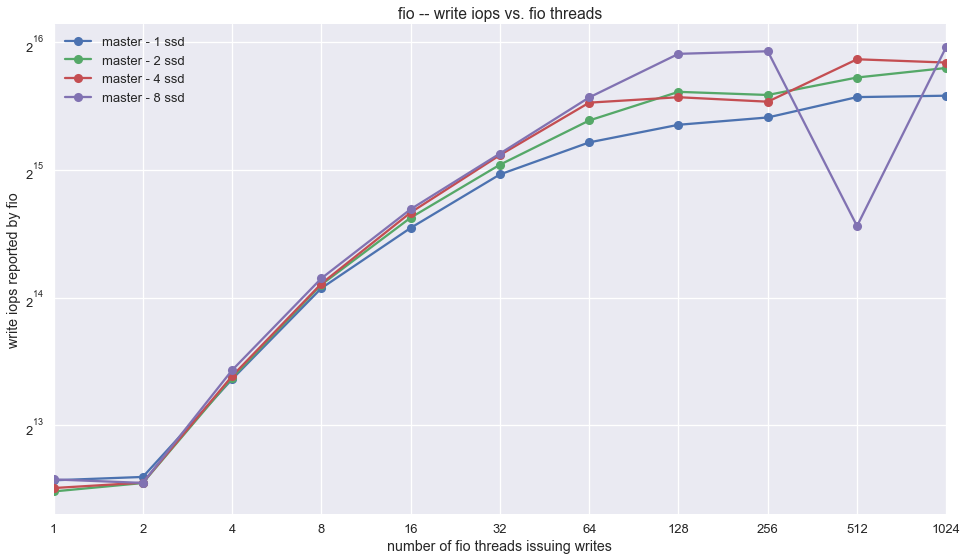

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,6081.281979,5724.187930,5831.002817,6110.864819
2,6193.430109,5992.133464,6003.883269,5996.466726
4,10525.549148,10602.323295,10704.021600,11053.115781
8,17245.391820,17582.530582,17675.038749,18190.946818
16,23916.386120,25283.673878,26001.033299,26475.919075
32,31972.100930,33703.103126,35505.091412,35805.759712
64,38042.494711,42845.326978,47195.903606,48550.296548
128,41857.180949,50046.280248,48609.209386,61510.189459
256,43551.615537,49201.882706,47440.791776,62375.402050
512,48639.359557,54095.265060,59720.733028,24161.456424


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

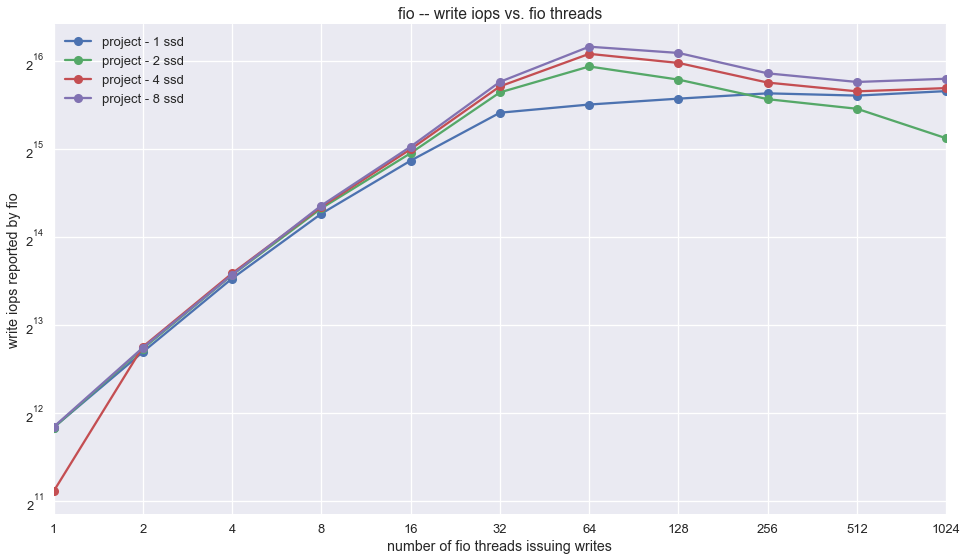

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,3640.539324,3634.689422,2200.529991,3656.689055
2,6603.773270,6781.320311,6881.735304,6832.936118
4,11789.836836,12121.479284,12272.674244,12147.514208
8,19653.022450,20503.783207,20749.454176,20956.867386
16,29852.554915,31666.777774,32681.160628,33338.594357
32,43558.698043,51120.153295,53602.256629,55558.990683
64,46455.710548,62706.026466,69277.314005,73290.090330
128,48665.761187,56542.150606,64480.525974,69766.730529
256,50742.688109,48454.012361,55228.232981,59393.466382
512,49852.602986,44930.392500,51546.897114,55499.308829


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

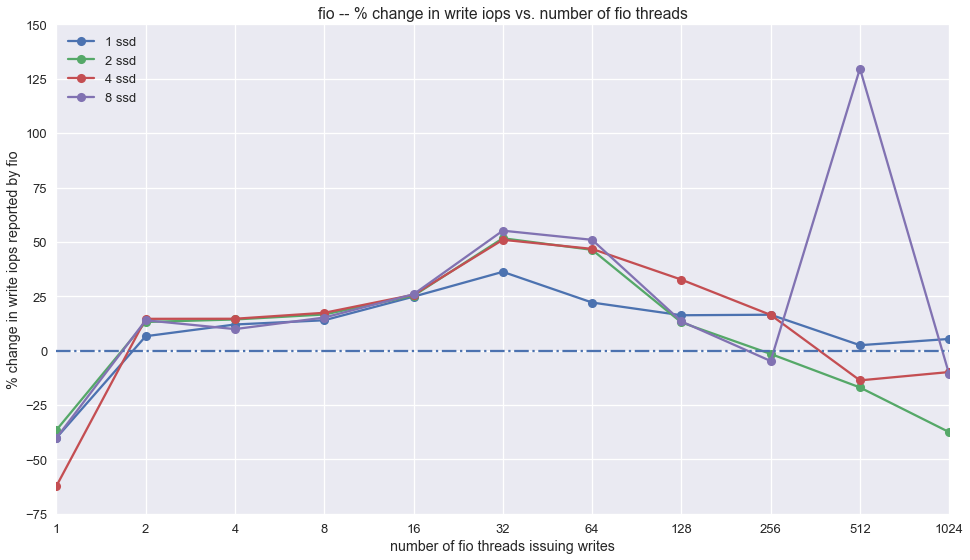

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-75, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 ssd,2 ssd,4 ssd,8 ssd
1,-40.135331,-36.502968,-62.261552,-40.160858
2,6.625459,13.170382,14.621404,13.949371
4,12.011608,14.328520,14.654797,9.901266
8,13.961009,16.614518,17.394109,15.204929
16,24.820509,25.245951,25.691776,25.920442
32,36.239711,51.677883,50.970620,55.167747
64,22.115311,46.354412,46.786710,50.957039
128,16.266218,12.979727,32.650843,13.423046
256,16.511609,-1.520004,16.415074,-4.780628
512,2.494366,-16.942098,-13.686764,129.701835


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

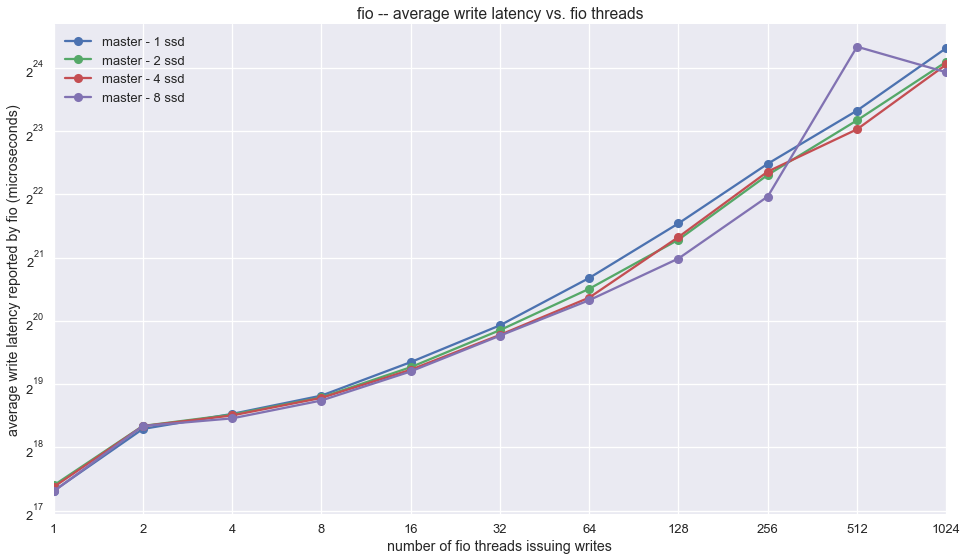

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,1.627596e+05,1.729258e+05,1.697717e+05,1.619240e+05
2,3.211691e+05,3.320184e+05,3.314003e+05,3.317411e+05
4,3.787499e+05,3.760264e+05,3.724069e+05,3.606736e+05
8,4.627901e+05,4.539029e+05,4.515554e+05,4.387327e+05
16,6.678553e+05,6.317498e+05,6.142514e+05,6.032695e+05
32,9.996003e+05,9.481952e+05,9.000854e+05,8.924716e+05
64,1.680042e+06,1.492264e+06,1.354676e+06,1.316643e+06
128,3.055899e+06,2.555820e+06,2.631528e+06,2.079327e+06
256,5.874966e+06,5.199513e+06,5.392631e+06,4.101659e+06
512,1.052055e+07,9.454677e+06,8.567692e+06,2.118133e+07


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

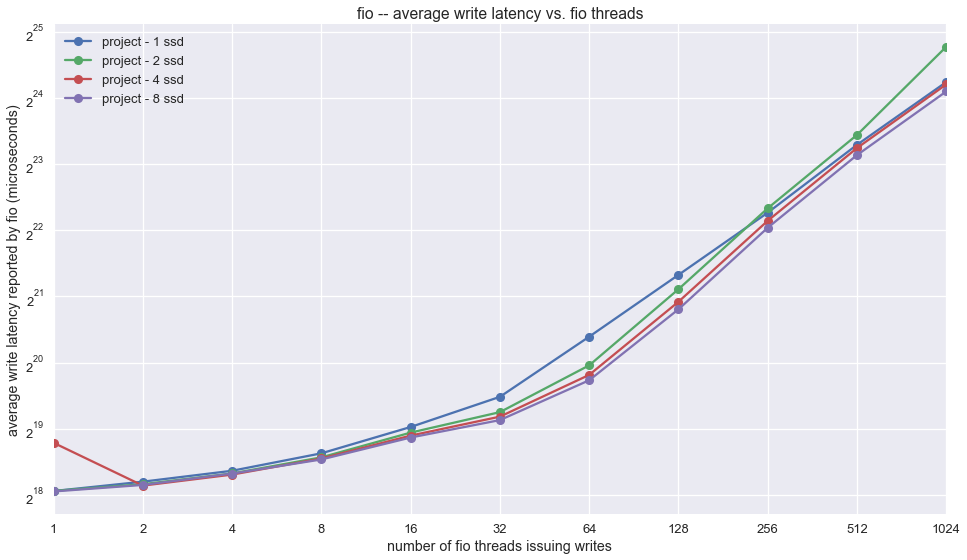

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,2.730150e+05,2.733755e+05,4.525890e+05,2.718025e+05
2,3.011317e+05,2.932577e+05,2.889718e+05,2.910592e+05
4,3.375633e+05,3.283457e+05,3.243464e+05,3.276402e+05
8,4.052756e+05,3.885378e+05,3.838966e+05,3.800654e+05
16,5.339480e+05,5.034213e+05,4.878345e+05,4.781823e+05
32,7.324308e+05,6.239125e+05,5.950914e+05,5.740804e+05
64,1.375138e+06,1.018419e+06,9.216250e+05,8.711588e+05
128,2.627474e+06,2.261020e+06,1.982689e+06,1.832124e+06
256,5.042143e+06,5.278506e+06,4.630836e+06,4.306188e+06
512,1.026430e+07,1.138345e+07,9.922821e+06,9.216534e+06


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

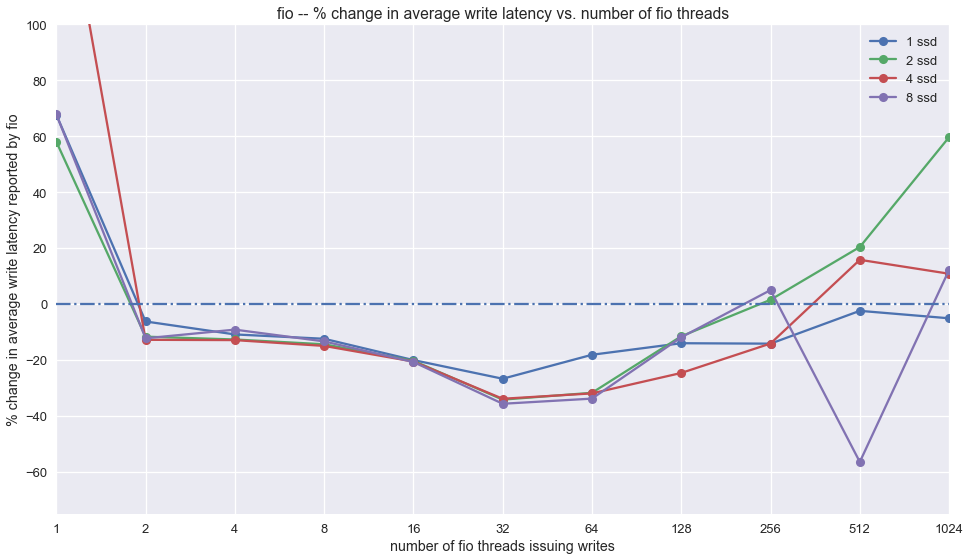

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-75, 100)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 ssd,2 ssd,4 ssd,8 ssd
1,67.741226,58.088286,166.586819,67.858095
2,-6.238900,-11.674263,-12.802807,-12.263139
4,-10.874350,-12.680154,-12.905378,-9.158816
8,-12.427783,-14.400678,-14.983492,-13.371984
16,-20.050349,-20.313176,-20.580641,-20.734878
32,-26.727627,-34.199992,-33.885011,-35.675226
64,-18.148621,-31.753439,-31.967115,-33.834846
128,-14.019601,-11.534428,-24.656360,-11.888614
256,-14.175789,1.519226,-14.126589,4.986515
512,-2.435682,20.400163,15.816736,-56.487457


## `%util` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%util` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -x 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%util` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%util` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%util` averaged across all disks in zpool vs. `fio` threads - master branch

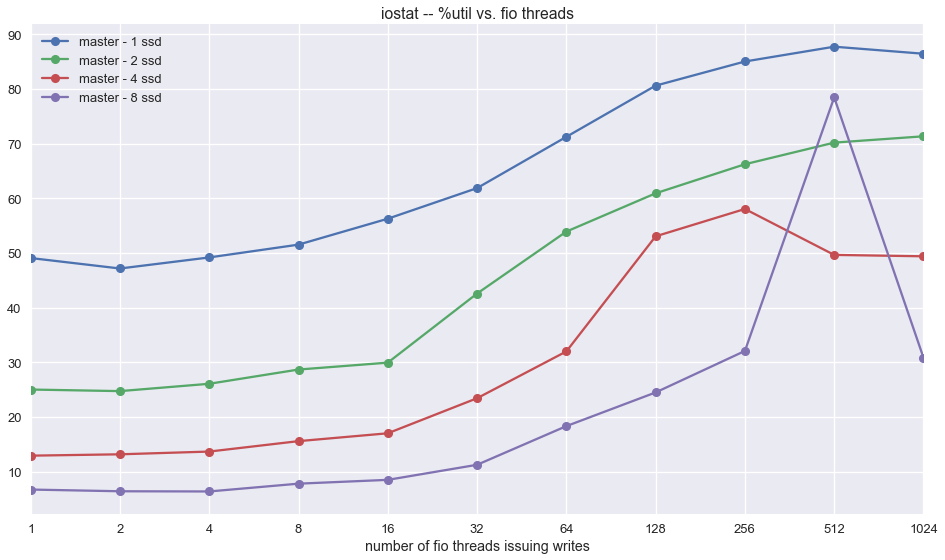

In [15]:
plot_iostat_column_dataframe(master_busy, '%util')

In [16]:
master_busy

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,49.098182,25.056909,12.967273,6.770909
2,47.185455,24.767273,13.214545,6.458182
4,49.207273,26.109091,13.716364,6.421818
8,51.549091,28.712727,15.621818,7.847273
16,56.288000,29.972182,17.058727,8.544000
32,61.883636,42.603636,23.466364,11.298000
64,71.258182,53.934545,32.024000,18.368000
128,80.617636,60.934000,53.068545,24.526909
256,85.030909,66.245091,58.067091,32.111091
512,87.736727,70.200000,49.671818,78.467455


### `%util` averaged across all disks in zpool vs. `fio` threads - project branch

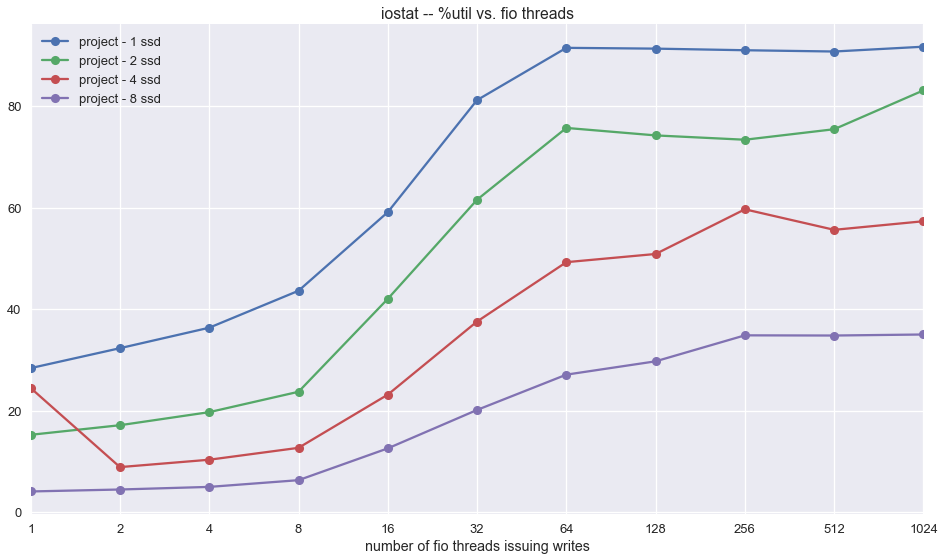

In [17]:
plot_iostat_column_dataframe(project_busy, '%util')

In [18]:
project_busy

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,28.378182,15.236364,24.458182,4.072727
2,32.305455,17.127273,8.872727,4.458182
4,36.341455,19.701818,10.325818,4.972364
8,43.621818,23.716364,12.669091,6.297091
16,59.112727,42.029091,23.151818,12.565091
32,81.193273,61.567273,37.564364,20.138182
64,91.490909,75.709818,49.255273,27.093273
128,91.333818,74.234182,50.870364,29.718727
256,91.018545,73.382909,59.672727,34.838182
512,90.766727,75.455273,55.629455,34.801091
